In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import emcee
from astropy.io import fits
from IPython.display import display, Math
from scipy.optimize import minimize
from specutils.manipulation import noise_region_uncertainty
from specutils.fitting import find_lines_threshold
from specutils import Spectrum1D, SpectralRegion
from astropy.modeling import models
from specutils import SpectralRegion
from specutils.fitting import estimate_line_parameters
from specutils.manipulation import extract_region
import astropy.units as u
from astropy.modeling.models import custom_model
from specutils.fitting import fit_lines
from scipy import interpolate
import keras

In [2]:
output_dir = 'Data/'
syn_num = 100
line_ = 15243.90  # Halpha in cm-1
spec_ic = 5

In [3]:
# Machine Learning Reference Spectrum
ref_spec = fits.open('Reference-Spectrum-R5000.fits')[1].data
channel = []
counts = []
for chan in ref_spec:  # Only want SN3 region
    channel.append(chan[0])
    counts.append(chan[1])
min_ = np.argmin(np.abs(np.array(channel)-14700))
max_ = np.argmin(np.abs(np.array(channel)-15600))
wavenumbers_syn = channel[min_:max_]

In [4]:
# Read in Data
Channels = []
Counts = []
sigma_info = []
velocity_info = []
res_info = []
for spec_ct in range(syn_num):  # Only ten percent in test set
    spectrum = fits.open(output_dir+'Spectrum_%i.fits'%(spec_ct))
    header = spectrum[0].header
    spec = spectrum[1].data
    channel = []
    counts = []
    for chan in spec:
        channel.append(chan[0])
        counts.append(chan[1])
    count_max = np.max(counts)
    counts = [count/count_max for count in counts]
    f = interpolate.interp1d(channel, counts, kind='slinear')
    Counts.append(f(wavenumbers_syn))
    Channels.append(channel)
    velocity_info.append([header['VELOCITY']])
    sigma_info.append([header['BROADEN']])
    res_info.append([header['RES']])


[166.3142798959598] [168.6181355744102]


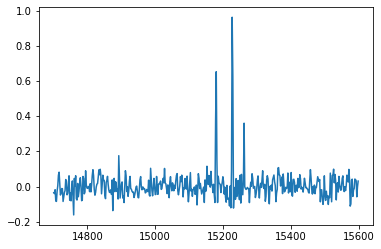

In [5]:
print(velocity_info[spec_ic], sigma_info[spec_ic])
plt.plot(wavenumbers_syn, Counts[spec_ic])

In [6]:
model = keras.models.load_model('R5000-PREDICTOR-I')

Spectrum = Counts[spec_ic].reshape(1, Counts[spec_ic].shape[0], 1)
predictions = model(Spectrum, training=False)
vel_ml = float(predictions[0][0])
broad_ml = float(predictions[0][1])
print(vel_ml, broad_ml)
line_halpha = 656.28
line_ml = 1e7/((vel_ml/3e5)*line_halpha + line_halpha)
print(line_ml)

157.83682250976562 21.230056762695312
15229.386144905882


In [7]:
'''spectrum = Spectrum1D(flux=Counts[spec_ic]*u.Jy, spectral_axis=wavenumbers_syn*u.cm)

#gauss_mod = models.Gaussian1D()
#def gauss_model(channel, A_, B_, x_, sigma_):
#    return A_*np.exp((-(channel-x_)**2)/(2*sigma_**2)) + B_
#def gauss_deriv(x, amplitude=1., frequency=1.):
#    return 2 * np.pi * amplitude * np.cos(2 * np.pi * frequency * x)
#gauss_mod = custom_model(gauss_model)#, fit_deriv=sine_deriv)
#sub_region = SpectralRegion(15100*u.cm, 15300*u.cm)
#sub_spectrum = extract_region(spectrum, sub_region)
#estimate_vals = estimate_line_parameters(sub_spectrum, gauss_mod)x
#print(gauss_mod)
noise_region = SpectralRegion(14600*u.cm, 14650*u.cm)
spectrum = noise_region_uncertainty(spectrum, noise_region)
lines = find_lines_threshold(spectrum, noise_factor=3)
line_ = lines['line_center'].value[0]
print(list(lines['line_center_index']))
print(spectrum[98])'''

"spectrum = Spectrum1D(flux=Counts[spec_ic]*u.Jy, spectral_axis=wavenumbers_syn*u.cm)\n\n#gauss_mod = models.Gaussian1D()\n#def gauss_model(channel, A_, B_, x_, sigma_):\n#    return A_*np.exp((-(channel-x_)**2)/(2*sigma_**2)) + B_\n#def gauss_deriv(x, amplitude=1., frequency=1.):\n#    return 2 * np.pi * amplitude * np.cos(2 * np.pi * frequency * x)\n#gauss_mod = custom_model(gauss_model)#, fit_deriv=sine_deriv)\n#sub_region = SpectralRegion(15100*u.cm, 15300*u.cm)\n#sub_spectrum = extract_region(spectrum, sub_region)\n#estimate_vals = estimate_line_parameters(sub_spectrum, gauss_mod)x\n#print(gauss_mod)\nnoise_region = SpectralRegion(14600*u.cm, 14650*u.cm)\nspectrum = noise_region_uncertainty(spectrum, noise_region)\nlines = find_lines_threshold(spectrum, noise_factor=3)\nline_ = lines['line_center'].value[0]\nprint(list(lines['line_center_index']))\nprint(spectrum[98])"

In [8]:
'''line_fluxes = [spectrum[val].flux.value[0] for val in list(lines['line_center_index'])]
line_axis = [spectrum[val].spectral_axis.value[0] for val in list(lines['line_center_index'])]

print(line_fluxes)
print(line_axis)
max_ind = np.argmax(line_fluxes)
max_line = line_axis[max_ind]
line_fluxes.pop(max_ind); line_axis.pop(max_ind)
try:
    max_ind2 = np.argmax(line_fluxes)
    max_line2 = line_axis[max_ind2]
    print(max_line, max_line2)
    model = 2
except:
    model = 1'''

"line_fluxes = [spectrum[val].flux.value[0] for val in list(lines['line_center_index'])]\nline_axis = [spectrum[val].spectral_axis.value[0] for val in list(lines['line_center_index'])]\n\nprint(line_fluxes)\nprint(line_axis)\nmax_ind = np.argmax(line_fluxes)\nmax_line = line_axis[max_ind]\nline_fluxes.pop(max_ind); line_axis.pop(max_ind)\ntry:\n    max_ind2 = np.argmax(line_fluxes)\n    max_line2 = line_axis[max_ind2]\n    print(max_line, max_line2)\n    model = 2\nexcept:\n    model = 1"

In [9]:
A_min = 0.1
A_max = 2
x_min = 15000
x_max = 15400
sigma_min = 0
sigma_max = 10

class Gaussian:
    def __init__(self, channel, params):
        A = params[0]; x = params[1]; sigma = params[2]
        self.func = A*np.exp((-(channel-x)**2)/(2*sigma**2))

# Update the model
def gaussian_model(channel, theta, models):
    """
    """
    f1 = 0.0
    for model_num in range(len(models)):
        params = theta[model_num*3:(model_num+1)*3]
        f1 += Gaussian(channel, params).func
    return f1


In [10]:
def log_likelihood(theta, x, y, yerr, model):
    """
    theta - list of parameters for gaussian fit
    """
    #if model == 1:
    #    A_,B_,x_,sigma_ = theta
    #    model = gaussian_model(x, A_, B_, x_, sigma_)
    #elif model == 2:
    #    A_,B_,x_,sigma_, A2_, x2_, sigma2_ = theta
    #    model = gaussian_model2(x, A_, B_, x_, sigma_, A2_, x2_, sigma2_)
    model = gaussian_model(x, theta, model)
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(2*np.pi*sigma2))


In [11]:
line_dict = {'Halpha': 656.280, 'NII6583': 658.341, 'NII6548': 654.803, 'SII6716': 671.647, 'SII6731': 673.085}
def line_vel_estimate(line_name):
    line_theo = line_dict[line_name]
    line_vel_est = 1e7/((vel_ml/3e5)*line_theo + line_theo)
    return line_vel_est
model = ['Halpha', 'NII6583']

nll = lambda *args: -log_likelihood(*args)
initial = np.ones((3*len(model)))
for mod in range(len(model)):
    val = 3*mod + 1
    initial[val] = line_vel_estimate(model[mod])
#if len(model) == 1:
#    initial = np.array([1, line_vel_estimate(model[0]),  1])
#    soln = minimize(nll, initial, args=(wavenumbers_syn, Counts[spec_ic], 1e-2, model))
#if len(model) == 2: 
#    initial = np.array([1, line_vel_estimate(model[0]),  1, 1, line_vel_estimate(model[1]), 1])
soln = minimize(nll, initial, args=(wavenumbers_syn, Counts[spec_ic], 1e-2, model))
init_var = soln.x

In [12]:
def log_prior(theta, model):
    for model_num in range(len(model)):
        params = theta[model_num*3:(model_num+1)*3]
    within_bounds = True  # Boolean to determine if parameters are within bounds
    for ct, param in enumerate(params):
        if ct%3 == 0:  # Amplitude parameter
            if param > A_min and param < A_max:
                pass
            else:
                within_bounds = False  # Value not in bounds
                break
        if ct%3 == 1:  # velocity parameter
            if param > x_min and param < x_max:
                pass
            else:
                within_bounds = False  # Value not in bounds
                break
        if ct%3 == 2:  # sigma parameter
            if param > sigma_min and param < sigma_max:
                pass
            else:
                within_bounds = False  # Value not in bounds
                break
    if within_bounds:
        return 0.0
    else:
        return -np.inf
    #A_,x_,sigma_ = theta
    #if A_min < A_ < A_max and x_min < x_ < x_max and sigma_min < sigma_ < sigma_max:
    #    return 0.0#np.log(1/((t_max-t_min)*(rp_max-rp_min)*(b_max-b_min)))
    #return -np.inf



In [13]:
def log_probability(theta, x, y, yerr, model):
    lp = log_prior(theta, model)
    '''if len(model) == 1:
        lp = log_prior(theta)
    elif len(model) == 2:
        lp = log_prior2(theta)
    else:
        print('Error with model definition')
        exit()'''
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr, model)

In [14]:
n_walkers = 16
n_dim = 3 * len(model)

init_ = init_var + 1e-4 * np.random.randn(n_walkers, n_dim)

sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_probability, args=(wavenumbers_syn, Counts[spec_ic], 1e-2, model))
sampler.run_mcmc(init_, 1000, progress=True);

100%|██████████| 1000/1000 [00:04<00:00, 245.47it/s]


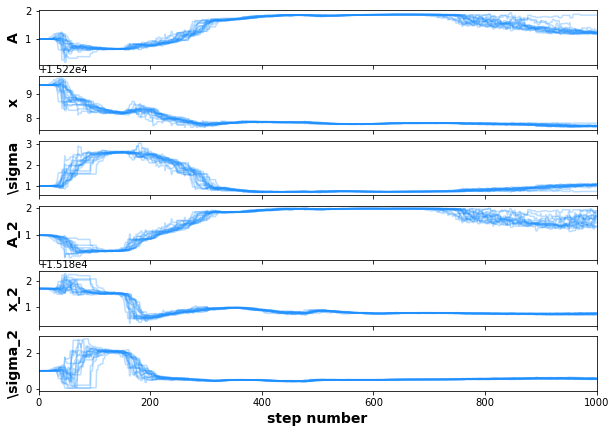

In [15]:
fig, axes = plt.subplots(n_dim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
if len(model) == 1:
    labels = [r"A", r"x", "sigma"]
elif len(model) == 2:
    labels = [r"A", r"x", r"\sigma", r"A_2", r"x_2", r"\sigma_2"]
for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", color='dodgerblue', alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], fontweight='bold', fontsize=14)
    #ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number", fontsize=14, fontweight='bold');
plt.savefig('Emcee-steps.png')

In [16]:
flat_samples = sampler.get_chain(discard=500, flat=True)
mean_ = []
for i in range(n_dim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    mean_.append(mcmc[1])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

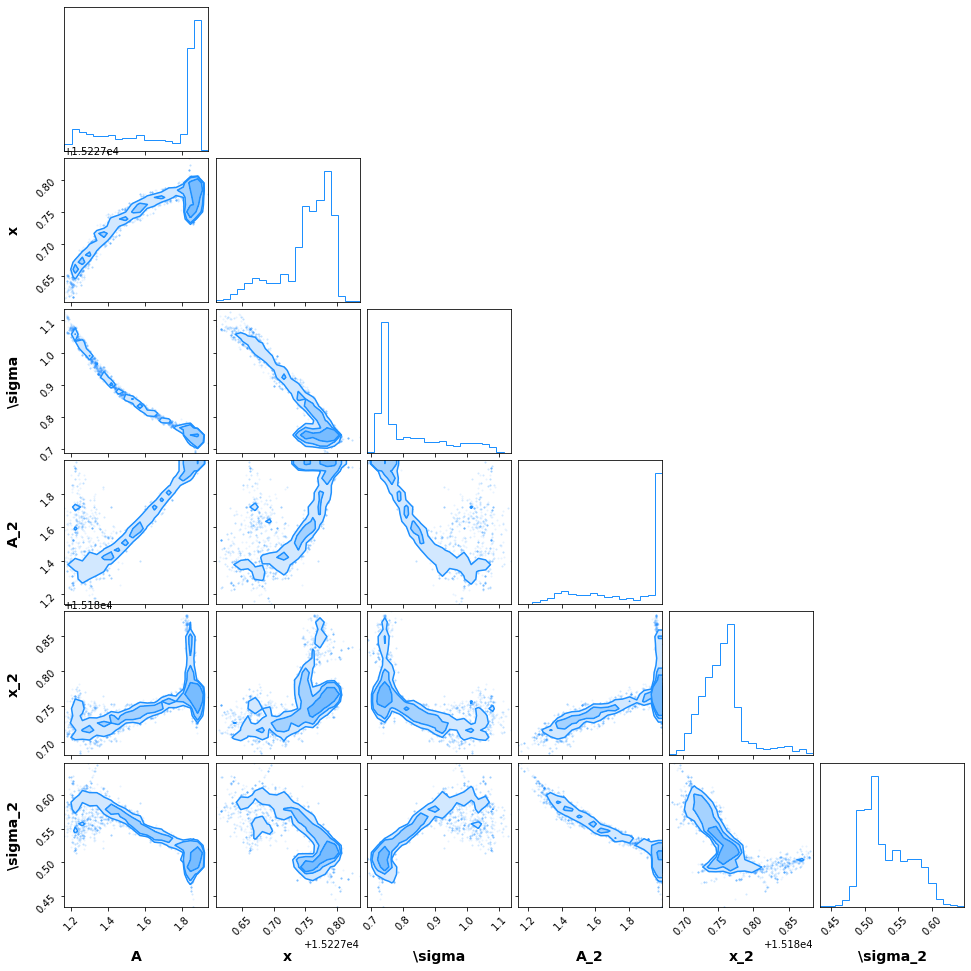

In [17]:
import corner
fig = corner.corner(
    flat_samples, labels=labels, color='dodgerblue', label_kwargs=dict(fontweight='bold', fontsize=14), fill_contours=True#, truths=[m_true, b_true, np.log(f_true)]
);
plt.plot()
plt.savefig('Emcee-Corner.png')

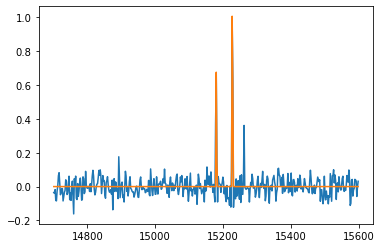

In [18]:
#if model == 1:
parameters = list(mean_)
#if model == 2:
    #parameters = [mean_[0], mean_[1],  mean_[2], mean_[3], mean_[4], mean_[5]]
final_model = gaussian_model(wavenumbers_syn, parameters, model)
plt.plot(wavenumbers_syn, Counts[spec_ic])
plt.plot(wavenumbers_syn, final_model)

In [19]:
l_calc = 1e7/mean_[1]  # Halpha
#print(l_calc)
l_shift = (l_calc - 656.28)/l_calc
#print(l_shift)
v = 3e5*l_shift
print("Calculated velocity: %.2f km/s"%v)
print("True Velocity: %.2f km/s"%velocity_info[spec_ic][0])
print("Velocity Error (percentage): %.2f"%(100*np.abs(v-velocity_info[spec_ic][0])/velocity_info[spec_ic][0]))

Calculated velocity: 189.75 km/s
True Velocity: 166.31 km/s
Velocity Error (percentage): 14.09


In [37]:
mean_[5]*3e5/(mean_[4])

10.301824274251983

In [24]:
mean_[2]

0.7562346305570885